<a href="https://colab.research.google.com/github/kashperova/iasa-nlp-course/blob/main/assignment_3/Validation_CommonLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVR
from sentence_transformers import SentenceTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Validation

I decided to skip EDA, data preprocessing and feature engineering steps. They can be found in another notebook ```assignment_2/Assignment2.ipynb```. I've just donwloaded updated dataset for modeling.

In [ ]:
content_dfrm = pd.read_csv("content_train.csv")
content_dfrm.head()

,content,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,prompt_id,text
0,0.205683,3,4,3,50,9,814d6b,the third wave was an experimentto see how peo...
1,-0.548304,1,3,2,36,6,ebad26,they would rub it up with soda to make the sme...
2,3.128928,9,13,38,142,25,3b9047,"in egypt, there were many occupations and soci..."
3,-0.210614,4,5,6,21,3,3b9047,the highest class was pharaohs these people we...
4,3.272894,23,14,30,133,18,814d6b,the third wave developed rapidly because the ...


In [ ]:
wording_dfrm =  pd.read_csv("wording_train.csv")
wording_dfrm.head()

,wording,cite,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,fk_score,prompt_id,text
0,0.380538,0,3,4,3,50,9,8.1,814d6b,the third wave was an experimentto see how peo...
1,0.506755,1,1,3,2,36,6,7.5,ebad26,they would rub it up with soda to make the sme...
2,4.231226,1,9,13,38,142,25,8.5,3b9047,"in egypt, there were many occupations and soci..."
3,-0.471415,1,4,5,6,21,3,5.3,3b9047,the highest class was pharaohs these people we...
4,3.219757,0,23,14,30,133,18,7.8,814d6b,the third wave developed rapidly because the ...


### Wodring Features description

- <b>wording</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>cite</b> - whether is proposed in prompt question to cite evidence from the text.
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary
- <b>fk_score</b> - Flesch-Kincaid readability score in student's summary


### Content Features description

- <b>wording</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>punctuation_count</b> - amount of punctuation in student's summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary

## Modeling
<b>Sentence embeddings</b>

In [ ]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")
content_dfrm['text_embeddings'] = content_dfrm['text'].apply(lambda x: sent_tr.encode(x))

In [ ]:
wording_dfrm['text_embeddings'] = content_dfrm['text_embeddings']

## K-fold cross-validation

In [ ]:
selected_columns_content = ['mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count']
selected_columns_wording = ['cite', 'mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count', 'fk_score']


<b>Content

</b>

In [ ]:
X = pd.concat([pd.DataFrame(content_dfrm['text_embeddings'].to_list()), content_dfrm[selected_columns_content]], axis=1)
X.columns = [str(x) for x in X.columns]
y = content_dfrm['content']

In [ ]:
svr_content = SVR(kernel='rbf', C=1)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = float('inf')

content_scores = []

for train_index, val_index in cv.split(X, content_dfrm['prompt_id']):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    svr_content.fit(X_train, y_train)

    y_pred = svr_content.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    content_scores.append(score)

    print(f'RMSE for this fold: {score}')

    if score < best_score:
        best_score = score
        with open('svr_content_k_fold.pkl','wb') as f:
          pickle.dump(svr_content, f)

c_mean_score = np.mean(content_scores)
c_std_score = np.std(content_scores)
c_range_score = [c_mean_score - 3*c_std_score, c_mean_score + 3*c_std_score]

print(f'Mean RMSE across folds: {c_mean_score}')
print(f'Std RMSE across folds: {c_std_score}')
print(f'3 Std RMSE range across folds: {c_range_score}')

RMSE for this fold: 0.5415677887792326
RMSE for this fold: 0.561714490394564
RMSE for this fold: 0.5203679097184966
RMSE for this fold: 0.5136864362752458
RMSE for this fold: 0.5201974264180221
Mean RMSE across folds: 0.5315068103171122
Std RMSE across folds: 0.017794775778254657
3 Std RMSE range across folds: [0.4781224829823483, 0.5848911376518762]


<b>Wording</b>

In [ ]:
X = pd.concat([pd.DataFrame(wording_dfrm['text_embeddings'].to_list()), wording_dfrm[selected_columns_wording]], axis=1)
X.columns = [str(x) for x in X.columns]
y = wording_dfrm['wording']

In [ ]:
svr_wording = SVR(kernel='rbf', C=1)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score = float('inf')

wording_scores = []

for train_index, val_index in cv.split(X, wording_dfrm['prompt_id']):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    svr_wording.fit(X_train, y_train)

    y_pred = svr_wording.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    wording_scores.append(score)

    print(f'RMSE for this fold: {score}')

    if score < best_score:
        best_score = score
        with open('svr_wording_k_fold.pkl','wb') as f:
          pickle.dump(svr_wording, f)

w_mean_score = np.mean(wording_scores)
w_std_score = np.std(wording_scores)
w_range_score = [w_mean_score - 3*w_std_score, w_mean_score + 3*w_std_score]

print(f'Mean RMSE across folds: {w_mean_score}')
print(f'Std RMSE across folds: {w_std_score}')
print(f'3 Std RMSE range across folds: {w_range_score}')

RMSE for this fold: 0.76440513783841
RMSE for this fold: 0.7874983628646707
RMSE for this fold: 0.7355483853026263
RMSE for this fold: 0.7442185800010197
RMSE for this fold: 0.7468939130607963
Mean RMSE across folds: 0.7557128758135045
Std RMSE across folds: 0.018451949620629914
3 Std RMSE range across folds: [0.7003570269516148, 0.8110687246753943]


<b>Join validation metrics</b>

In [ ]:
mean_score = (w_mean_score + c_mean_score) / 2
std_score = (w_std_score + c_std_score) / 2
range_score = [mean_score - 3*std_score, mean_score + 3*std_score]

print(f'Mean RMSE across folds: {mean_score}')
print(f'Std RMSE across folds: {std_score}')
print(f'3 Std RMSE range across folds: {range_score}')

Mean RMSE across folds: 0.6436098430653083
Std RMSE across folds: 0.018123362699442286
3 Std RMSE range across folds: [0.5892397549669814, 0.6979799311636352]


<b>LB metrics</b>

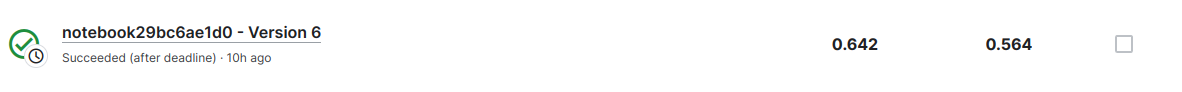

<b>Comments</b>

- Private score is 0.642 (87% of test data)
- Public score is 0.564 (13% of test data)

Obviously, there is model overfitting, however private score is approximetly equal to mean rmse across folds.

## Group K-fold cross-validation


<b>Content

</b>

In [ ]:
X = pd.concat([pd.DataFrame(content_dfrm['text_embeddings'].to_list()), content_dfrm[selected_columns_content]], axis=1)
X.columns = [str(x) for x in X.columns]
y = content_dfrm['content']
groups = content_dfrm['prompt_id']

In [ ]:
svr_content = SVR(kernel='rbf', C=1)

In [ ]:
cv = GroupKFold(n_splits=4)
best_score = float('inf')

content_scores = []

for train_index, val_index in cv.split(X, y, groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    svr_content.fit(X_train, y_train)

    y_pred = svr_content.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    content_scores.append(score)

    print(f'RMSE for this fold: {score}')

    if score < best_score:
        best_score = score
        with open('svr_content_group_fold.pkl','wb') as f:
          pickle.dump(svr_content, f)

c_mean_score = np.mean(content_scores)
c_std_score = np.std(content_scores)
c_range_score = [c_mean_score - 3*c_std_score, c_mean_score + 3*c_std_score]

print(f'Mean RMSE across folds: {c_mean_score}')
print(f'Std RMSE across folds: {c_std_score}')
print(f'3 Std RMSE range across folds: {c_range_score}')

RMSE for this fold: 0.4932395935612595
RMSE for this fold: 0.5882739030761271
RMSE for this fold: 0.5938120949575216
RMSE for this fold: 0.6008153587056856
Mean RMSE across folds: 0.5690352375751485
Std RMSE across folds: 0.043985721156293435
3 Std RMSE range across folds: [0.4370780741062682, 0.7009924010440288]


<b>Wording</b>

In [ ]:
X = pd.concat([pd.DataFrame(wording_dfrm['text_embeddings'].to_list()), wording_dfrm[selected_columns_wording]], axis=1)
X.columns = [str(x) for x in X.columns]
y = wording_dfrm['wording']

In [ ]:
svr_wording = SVR(kernel='rbf', C=1)

In [ ]:
cv = GroupKFold(n_splits=4)
best_score = float('inf')
wording_scores = []

for train_index, val_index in cv.split(X, y, groups):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    svr_wording.fit(X_train, y_train)

    y_pred = svr_wording.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    wording_scores.append(score)

    print(f'RMSE for this fold: {score}')

    if score < best_score:
        best_score = score
        with open('svr_wording_group_fold.pkl','wb') as f:
          pickle.dump(svr_wording, f)

w_mean_score = np.mean(wording_scores)
w_std_score = np.std(wording_scores)
w_range_score = [w_mean_score - 3*w_std_score, w_mean_score + 3*w_std_score]

print(f'Mean RMSE across folds: {w_mean_score}')
print(f'Std RMSE across folds: {w_std_score}')
print(f'3 Std RMSE range across folds: {w_range_score}')

RMSE for this fold: 0.7178460516792529
RMSE for this fold: 0.8532205284896403
RMSE for this fold: 0.8321933752327547
RMSE for this fold: 1.0515486643032965
Mean RMSE across folds: 0.863702154926236
Std RMSE across folds: 0.12006558794058081
3 Std RMSE range across folds: [0.5035053911044935, 1.2238989187479785]


<b>Join validation metrics</b>

In [ ]:
mean_score = (w_mean_score + c_mean_score) / 2
std_score = (w_std_score + c_std_score) / 2
range_score = [mean_score - 3*std_score, mean_score + 3*std_score]

print(f'Mean RMSE across folds: {mean_score}')
print(f'Std RMSE across folds: {std_score}')
print(f'3 Std RMSE range across folds: {range_score}')

Mean RMSE across folds: 0.7163686962506923
Std RMSE across folds: 0.08202565454843712
3 Std RMSE range across folds: [0.470291732605381, 0.9624456598960036]


<b>LB metrics</b>

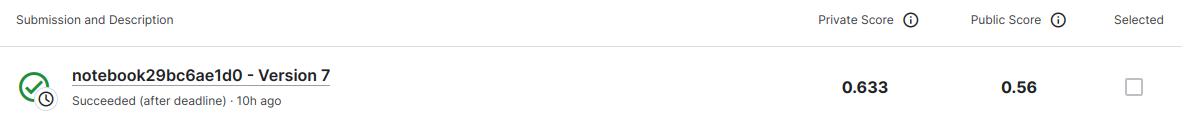

<b>Comments</b>

- Private score is 0.633 (87% of test data)
- Public score is 0.56 (13% of test data)

Private score falls within one standard deviation

### Thoughts

<b>K-fold cross-validation stratified by prompt id</b>

- As local validation mean RMSE is close to LB, it means that this type of validation represents private LB distribution well. However, it's so significant difference between local validation and public score, so  I suppose model was overfitted on particular prompts in train set.
- Unfortunately, I started doing my homework too late, so I didn’t do enough experiments to evaluate the correlation.

<br></br>
<b>Group K-fold cross-validation grouped by prompt id</b>

- Surprisingly, LB scores, both public and private, are lower than those from Group K-fold. So model generalizes to unseen prompts better when group k-fold was used. So it seems to me that group k-fold is more robust validation method here.